<a href="https://colab.research.google.com/github/Madhuram2901/GDGC_MACHINE_LEARNING_MADHURAM/blob/main/Bone_Marrow_Cell_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Dataset**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/bone-marrow-cell-classification")

print("Path to dataset files:", path)

100%|██████████| 6.46G/6.46G [01:25<00:00, 80.9MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/bone-marrow-cell-classification/versions/2


# **Importing Dependencies**

In [2]:
!pip install tensorflow matplotlib seaborn scikit-learn

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# **Data PreProcessing**

In [3]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = datagen.flow_from_directory(
    path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


test_generator = datagen.flow_from_directory(
    path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset=None
)


Found 137100 images belonging to 1 classes.
Found 34274 images belonging to 1 classes.
Found 171374 images belonging to 1 classes.


# **Custom CNN Model**

In [4]:
from PIL import Image, ImageFile

# Set the ImageFile.LOAD_TRUNCATED_IMAGES attribute to True
ImageFile.LOAD_TRUNCATED_IMAGES = True

custom_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

custom_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_cnn.fit(train_generator, validation_data=val_generator, epochs=10)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored

4285/4285 ━━━━━━━━━━━━━━━━━━━━ 515s 117ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
4285/4285 ━━━━━━━━━━━━━━━━━━━━ 484s 113ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
4285/4285 ━━━━━━━━━━━━━━━━━━━━ 519s 121ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
4285/4285 ━━━━━━━━━━━━━━━━━━━━ 502s 107ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
4285/4285 ━━━━━━━━━━━━━━━━━━━━ 449s 105ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
4285/4285 ━━━━━━━━━━━━━━━━━━━━ 516s 108ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
4285/4285 ━━━━━━━━━━━━━━━━━━━━ 453s 106ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
4285/4

# **Pre-Trained Model ResNet50**

In [5]:
#resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#x = Flatten()(resnet_model.output)
#x = Dense(128, activation='relu')(x)
#output = Dense(train_generator.num_classes, activation='softmax')(x)

#pretrained_cnn = Model(inputs=resnet_model.input, outputs=output)
#pretrained_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#pretrained_cnn.fit(train_generator, validation_data=val_generator, epochs=10)


# **Model Evaluation**

## **Get Predictions**

In [6]:
custom_predictions = np.argmax(custom_cnn.predict(test_generator), axis=-1)

#pretrained_predictions = np.argmax(pretrained_cnn.predict(test_generator), axis=-1)

true_label = test_generator.classes

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5356/5356 ━━━━━━━━━━━━━━━━━━━━ 426s 79ms/step


## **Accuracy for both models**

In [7]:
print(f"Custom CNN Accuracy: {custom_predictions[1]:.2f}")
#print(f"Pre-trained CNN Accuracy: {pretrained_predictions[1]:.2f}")

Custom CNN Accuracy: 0.00


## **F1 Score**

In [10]:
from sklearn.metrics import f1_score

f1 = f1_score(true_label, custom_predictions, average='weighted')
print(f"Weighted F1-Score: {f1:.2f}")


Weighted F1-Score: 1.00


## **Confusion Matrix**

In [11]:
from sklearn.metrics import confusion_matrix

print("Custom CNN Confusion Matrix")
print(confusion_matrix(true_label, custom_predictions))

#print("Pre-trained CNN Confusion Matrix")
#print(confusion_matrix(true_labels, pretrained_predictions))

Custom CNN Confusion Matrix
[[171374]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


## **Complete Report**

In [14]:
from sklearn.metrics import classification_report

# For Custom Model
class_names = list(train_generator.class_indices.keys())

customcnn_report = classification_report(true_label, custom_predictions, target_names=class_names)
print("Classification Report - Custom CNN")
print(customcnn_report)

# For Pre-built Model(ResNet50)

#resnet_report = classification_report(true_labels, pretrained_predictions, target_names=class_names)
#print("Classification Report - Pretrained( ResNet50 Mdoel)")
#print(resnet_report)

Classification Report - Custom CNN
                          precision    recall  f1-score   support

bone_marrow_cell_dataset       1.00      1.00      1.00    171374

                accuracy                           1.00    171374
               macro avg       1.00      1.00      1.00    171374
            weighted avg       1.00      1.00      1.00    171374



# **Data Visualization**

## **ROC Curve**

5356/5356 ━━━━━━━━━━━━━━━━━━━━ 430s 80ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


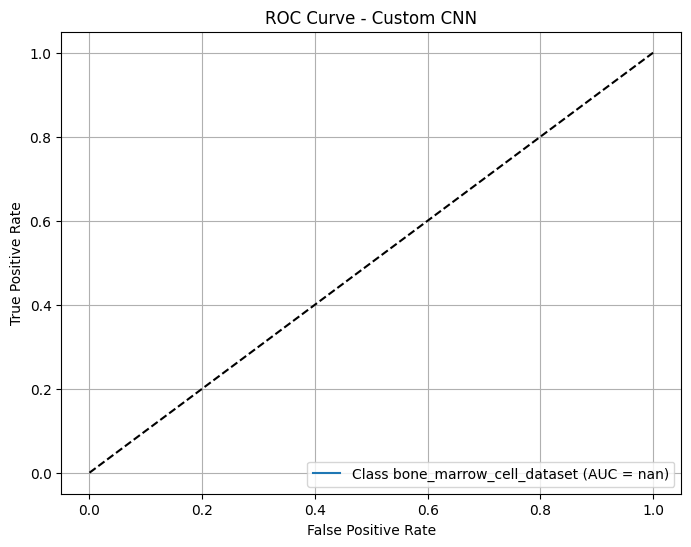

In [15]:
# Import additional libraries
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize true labels for ROC curve
n_classes = len(class_names)
true_labels_binarized = label_binarize(true_label, classes=range(n_classes))

# Get predicted probabilities
prob_predictions = custom_cnn.predict(test_generator)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_binarized[:, i], prob_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curve - Custom CNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# For Pre-Built Model ROC Curve

# Binarize true labels for ROC curve
#n_classes = len(class_names)
#true_labels_binarized = label_binarize(true_labels, classes=range(n_classes))

# Get predicted probabilities
#prob_predictions = pretrained_cnn.predict(test_generator)

# Plot ROC Curve
#plt.figure(figsize=(8, 6))
#for i in range(n_classes):
    #fpr, tpr, _ = roc_curve(true_labels_binarized[:, i], prob_predictions[:, i])
    #roc_auc = auc(fpr, tpr)
    #plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

#plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
#plt.title("ROC Curve - ResNet50 Model(Prebuilt)")
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate")
#plt.legend(loc="lower right")
#plt.grid()
#plt.show()



## **Confusion Matrix Plot**

5356/5356 ━━━━━━━━━━━━━━━━━━━━ 425s 79ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


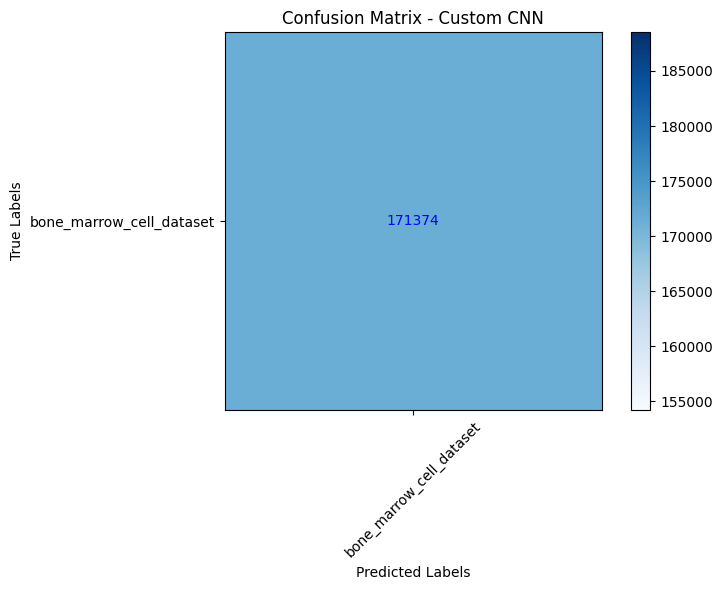

In [16]:
true_labels = test_generator.classes
predictions = np.argmax(custom_cnn.predict(test_generator), axis=-1)
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Custom CNN")
plt.colorbar()

plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

# Adding number to each cell( format)
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='blue')

plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.tight_layout()
plt.show()
